# Imports

In [1]:
# Import necessary libraries for mathematical operations and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

# Import astropy modules for working with astronomical data
import astropy.units as u
from astropy.visualization import simple_norm, SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.coordinates import angular_separation, Angle, SkyCoord
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
# Import os for directory operations
import os
# Import astroalign for aligning astronomical images
import astroalign as align
# Import twirl for peak finding and WCS (World Coordinate System) computations
from twirl import find_peaks
from twirl import gaia_radecs
from twirl.geometry import sparsify
from twirl import compute_wcs
# Import photutils for aperture photometry
from photutils.aperture import SkyCircularAperture
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from pylab import figure, cm
# Import pandas for data manipulation
import pandas as pd

import random

In [2]:
#Constnats
# BLUE_FILTER_COLOR =  'Blues'
# RED_FILTER_COLOR =  'Reds'

BLUE_FILTER_COLOR =  cm.grey
RED_FILTER_COLOR =  cm.grey

# Helper funcitons

In [3]:
def get_filename(directory):
    '''
    This gives all the filenames that are in a folder and returns them in list format
    '''
    filename_list=[]
    for filename in os.scandir(directory):
        if os.path.isfile(filename):
            filename_list.append(filename)
    return(filename_list)

def stack_frames(file_list):
    '''
    This takes a list of filenames
    Loads the data, averages all the images together
    Returns a master image
    '''
    imgs1=fits.open(file_list[0])
    data=imgs1[0].data

    height=len(data[:,0])
    width=len(data[0,:])
    
    master_img=np.zeros((height, width))
    count=0
    for file in file_list:
        count+=1
        imgs=fits.open(file)
        img_data=imgs[0].data
        master_img=master_img+img_data

    master_img=master_img/count

    return master_img

def correct_lights(light, dark, norm_flats_bias):
    '''
    light = list of light file names
    dark = master dark image
    norm_flats_bias = normalized bias subtracted flat images

    returns - list of image HDUs
    '''
    corr_HDU_list=[]
    for file in light:
        light_imgs=fits.open(file)
        light_data=light_imgs[0].data
        #light_header=light_imgs[0].header
        light_corr=(light_data-dark)/norm_flats_bias
        corr_HDU_list.append(light_corr)
    return corr_HDU_list

def align_image(list_of_images, reference_image):
    '''
    under costruction
    '''
    height=len(reference_image[:,0])
    width=len(reference_image[0,:])
    Master_image=np.zeros((height, width))
    count=0

    for image in list_of_images:
        count+=1
        aligned_image, footprint=align.register(image, reference_image)
        Master_image=Master_image+aligned_image

    Master_image=Master_image/count

    return Master_image

# Target

In [4]:
DIRECTORY="m2/"
# DIRECTORY="m13/"

# Gather all the files

In [29]:
#Get the file directory
darks_directory     = DIRECTORY + "darks/120/"
bias_directory      = DIRECTORY + "bias/2x2/"

flats1B_directory   = DIRECTORY + "Night 1/flats/B"
flats1R_directory   = DIRECTORY + "Night 1/flats/R"
flats2B_directory   = DIRECTORY + "Night 2/flats/B"
flats2R_directory   = DIRECTORY + "Night 2/flats/R"

light1B_directory   = DIRECTORY + "Night 1/B"
light1R_directory   = DIRECTORY + "Night 1/R"
light2B_directory   = DIRECTORY + "Night 2/B"
light2R_directory   = DIRECTORY + "Night 2/R"

#Create arays of file names, it's easier to reference them
darks_files         = get_filename(darks_directory)
bias_files          = get_filename(bias_directory)

flats1B_files       = get_filename(flats1B_directory)
flats1R_files       = get_filename(flats1R_directory)
flats2B_files       = get_filename(flats2B_directory)
flats2R_files       = get_filename(flats2R_directory)

light1B_files       = get_filename(light1B_directory)
light1R_files       = get_filename(light1R_directory)
light2B_files       = get_filename(light2B_directory)
light2R_files       = get_filename(light2R_directory)

print("Detected " + str(len(darks_directory)) + " dark images")
print("Detected " + str(len(bias_files)) + " bias images")
print("Detected " + str(len(flats1B_files)) + " Blue Filter images from Nov 2nd 2024")
print("Detected " + str(len(flats1R_files)) + " Red Filter images from Nov 2nd 2024")
print("Detected " + str(len(flats2B_files)) + " Blue Filter images from Nov 5th 2024")
print("Detected " + str(len(flats2R_files)) + " Red Filter images from Nov 5th 2024")

Detected 13 dark images
Detected 65 bias images
Detected 15 Blue Filter images from Nov 2nd 2024
Detected 15 Red Filter images from Nov 2nd 2024
Detected 15 Blue Filter images from Nov 5th 2024
Detected 15 Red Filter images from Nov 5th 2024


# Make master bias and darks

In [6]:
master_bias = stack_frames(bias_files) 
master_dark = stack_frames(darks_files)

# Make master flats

In [ ]:
#stack flat images for each day & filter to creat 4 master flats
flat1B_img = stack_frames(flats1B_files)
flat1R_img = stack_frames(flats1R_files)
flat2B_img = stack_frames(flats2B_files)
flat2R_img = stack_frames(flats2R_files)

#Subtract the bias from the flats
flat1B_bias = flat1B_img - master_bias 
flat1R_bias = flat1R_img - master_bias
flat2B_bias = flat2B_img - master_bias
flat2R_bias = flat2R_img - master_bias

#Normalize by dividing by the maximum value of the array
master_flat_1B = flat1B_bias / np.max(flat1B_bias) 
master_flat_1R = flat1R_bias / np.max(flat1R_bias)
master_flat_2B = flat2B_bias / np.max(flat2B_bias)
master_flat_2R = flat2R_bias / np.max(flat2R_bias)


# Make master light

In [8]:
master_light_1B = correct_lights(light1B_files, master_dark, master_flat_1B)
master_light_1R = correct_lights(light1R_files, master_dark, master_flat_1R)
master_light_2B = correct_lights(light2B_files, master_dark, master_flat_2B)
master_light_2R = correct_lights(light2R_files, master_dark, master_flat_2R)

# Choose a reference image

In [9]:
#get a random image from all the light images to use as reference image
random_number = random.randint(1,4)

if (random_number == 0): 

    random_file_index = random.randint(0,len(light1B_files)-1)
    ref_img = fits.open(light1B_files[random_file_index])

elif (random_number == 2):
    
    random_file_index = random.randint(0,len(light1R_files)-1)
    ref_img = fits.open(light1R_files[random_file_index])

elif (random_number == 3):
 
    random_file_index = random.randint(0,len(light2B_files)-1)
    ref_img = fits.open(light1B_files[random_file_index])

else:

    random_file_index = random.randint(0,len(light2R_files)-1)
    ref_img = fits.open(light1R_files[random_file_index])


# Get the data off the reference image

In [10]:
#get the header and the actual image from the choosen reference image
ref_header   = ref_img[0].header # this header will be stamped on any fits I make
ref_data     = ref_img[0].data   # this is be use for allighining light frames

# Alighn light frame from each filters

In [11]:
# make a list of all the B and R filter of the lights 
b_filter_lights = master_light_1B + master_light_2B
r_filter_lights = master_light_1R + master_light_2R

# alligh the lights using that random image we picked
master_Bfilter_light = align_image(b_filter_lights, ref_data)
master_Rfilter_light = align_image(r_filter_lights, ref_data)

# create the fits file to work with
b_filter_fits = fits.PrimaryHDU(master_Bfilter_light, ref_header)
r_filter_fits = fits.PrimaryHDU(master_Rfilter_light, ref_header)

# Save the master lights as fits files

In [12]:
# locate the place you wanna save the fits files
output_directory_b_filter = DIRECTORY + "Light_B.fits"
output_directory_r_filter = DIRECTORY + "Light_R.fits"

# write the files to drive
b_filter_fits.writeto(output_directory_b_filter, overwrite=True)
b_filter_fits.writeto(output_directory_r_filter, overwrite=True)

# Let's take a look at what we have so far

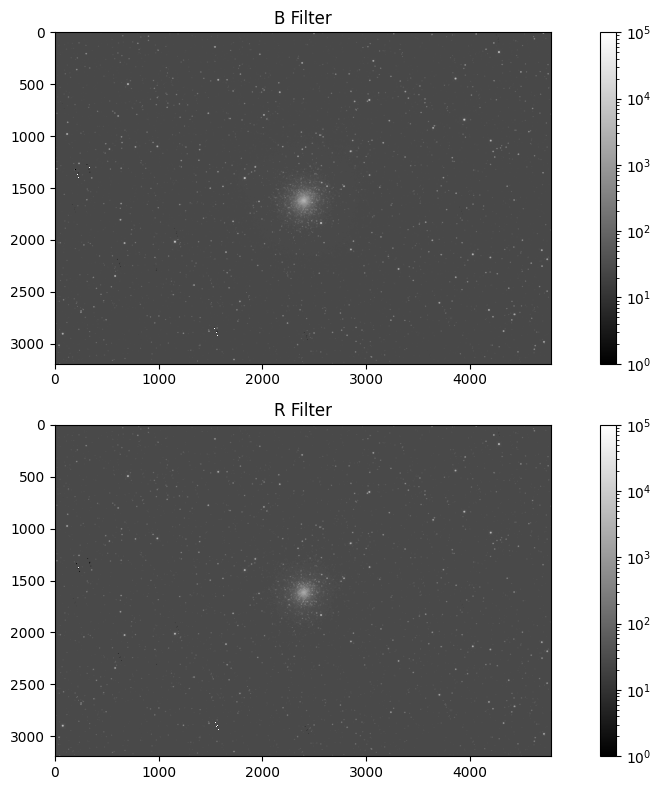

<Figure size 640x480 with 0 Axes>

In [13]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the B filter image in the first subplot
ax1.imshow(b_filter_fits.data, cmap = BLUE_FILTER_COLOR, norm=LogNorm(vmin=1, vmax=100000))
ax1.set_title('B Filter')

# Plot the R filter image in the second subplot
ax2.imshow(r_filter_fits.data, cmap = RED_FILTER_COLOR, norm=LogNorm(vmin=1, vmax=100000))
ax2.set_title('R Filter')

# Add colorbars to both subplots
fig.colorbar(ax1.imshow(b_filter_fits.data, cmap = BLUE_FILTER_COLOR, norm = LogNorm( vmin = 1, vmax = 100000 )), ax=ax1)
fig.colorbar(ax2.imshow(r_filter_fits.data, cmap = RED_FILTER_COLOR, norm = LogNorm( vmin = 1, vmax = 100000 )), ax=ax2)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Save the figure to the drive
output_filepath = DIRECTORY + "B & R filter lights.jpg"
plt.savefig(output_filepath, format='jpg')

# Display the plot
plt.show()
plt.clf()

# Let's define a small subsection

In [14]:
# Define the crop dimensions
crop_x_start = 2300
crop_x_end = 2700
crop_y_start = 1000
crop_y_end = 1400

# Calculate the width and height based on crop dimensions
crop_width = crop_x_end - crop_x_start
crop_height = crop_y_end - crop_y_start

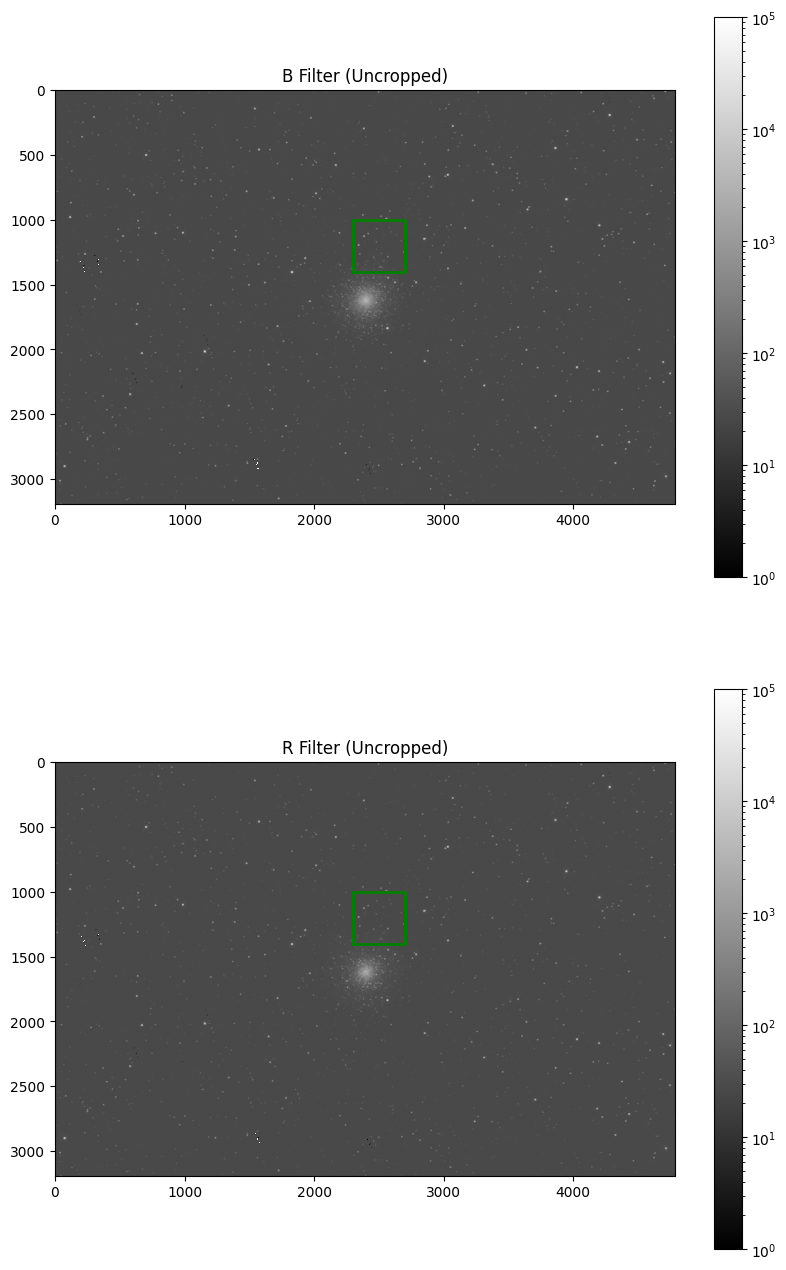

<Figure size 640x480 with 0 Axes>

In [15]:

# Create the first figure with uncropped images and green patches
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16))

# Plot the uncropped B filter image with a green rectangle
img1 = ax1.imshow(b_filter_fits.data, cmap= BLUE_FILTER_COLOR, norm=LogNorm(vmin=1, vmax=100000))
rect_b = Rectangle((crop_x_start, crop_y_start), crop_width, crop_height, linewidth=2, edgecolor='green', facecolor='none')
ax1.add_patch(rect_b)
ax1.set_title('B Filter (Uncropped)')
fig1.colorbar(img1, ax=ax1)

# Plot the uncropped R filter image with a green rectangle
img2 = ax2.imshow(r_filter_fits.data, cmap= RED_FILTER_COLOR, norm=LogNorm(vmin=1, vmax=100000))
rect_r = Rectangle((crop_x_start, crop_y_start), crop_width, crop_height, linewidth=2, edgecolor='green', facecolor='none')
ax2.add_patch(rect_r)
ax2.set_title('R Filter (Uncropped)')
fig1.colorbar(img2, ax=ax2)

# Save the first figure 
fig1.savefig(DIRECTORY + "subsection overlay.jpg", format='jpg')

# Display the plot
plt.show()
plt.clf()

# Cut out the small subsection

In [16]:
# Crop the images based on the defined dimensions
cropped_b_filter_img = b_filter_fits.data[crop_y_start:crop_y_end, crop_x_start:crop_x_end]
cropped_r_filter_img = r_filter_fits.data[crop_y_start:crop_y_end, crop_x_start:crop_x_end]

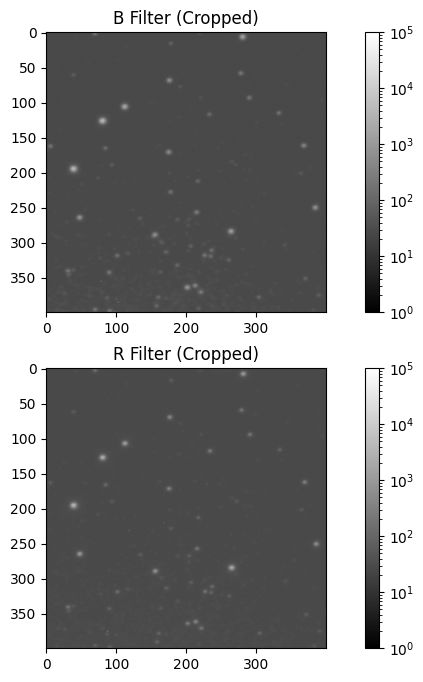

<Figure size 640x480 with 0 Axes>

In [17]:
# Create the second figure with cropped images
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the cropped B filter image
img3 = ax3.imshow(cropped_b_filter_img, cmap= BLUE_FILTER_COLOR, norm=LogNorm(vmin=1, vmax=100000))
ax3.set_title('B Filter (Cropped)')
fig2.colorbar(img3, ax=ax3)

# Plot the cropped R filter image
img4 = ax4.imshow(cropped_r_filter_img, cmap= RED_FILTER_COLOR, norm=LogNorm(vmin=1, vmax=100000))
ax4.set_title('R Filter (Cropped)')
fig2.colorbar(img4, ax=ax4)

# Save the second figure
fig2.savefig(DIRECTORY + "cropped_lights.jpg", format='jpg')

# Display the plot
plt.show()
plt.clf()

# Find the stats of the cropped images

In [18]:
# Calculate statistics (mean, median, and standard deviation) for the subsets of blue and red filter data
b_mean, b_median, b_std = sigma_clipped_stats(cropped_b_filter_img, sigma = 3.0)
r_mean, r_median, r_std = sigma_clipped_stats(cropped_r_filter_img, sigma = 3.0)


# Use stats in DAOStarFinder to locate sources

In [19]:
# initialise DAO Star Finder. Use the stats to find a suatitable thrushold
finder_for_b_filter = DAOStarFinder(fwhm = 5.0, threshold = 3.*b_std)
finder_for_r_filter = DAOStarFinder(fwhm = 5.0, threshold = 3.*r_std)

# make a background-subtracted image.
no_background_b_filter_img = cropped_b_filter_img - b_median
no_background_r_filter_img = cropped_r_filter_img - r_median

# run DAO star finder to find sources in B & R filter images that have been cropped
# DAOStarFinder returns a table with properties it found of each star it detected
b_filter_sources = finder_for_b_filter(no_background_b_filter_img)
r_filter_sources = finder_for_r_filter(no_background_r_filter_img)

# Let's take a look at what we found

In [20]:
# get the name of the colums that store the x and y position of the detected stars

# While we're diging in the table, make it only 2 decimal places
for col in b_filter_sources.colnames:  
    if col not in ('id', 'npix'): # dont mess with id & npix coloums in b filter cropped image
        b_filter_sources[col].info.format = '%.2f'

for col in r_filter_sources.colnames:  
    if col not in ('id', 'npix'):  # dont mess with id & npix coloums in r filter cropped image
        r_filter_sources[col].info.format = '%.2f'

#print the table to find the col names of interst
b_filter_sources.pprint_all()

 id xcentroid ycentroid sharpness roundness1 roundness2 npix   peak    flux    mag   daofind_mag
--- --------- --------- --------- ---------- ---------- ---- ------- -------- ------ -----------
  1     10.08      2.02      0.44      -0.20      -0.35   49    2.26    17.59  -3.11       -0.50
  2     41.48      3.17      0.46      -0.32      -0.58   49    6.23   101.49  -5.02       -1.26
  3     69.38      2.80      0.53      -0.22      -0.22   49  171.86  2844.99  -8.64       -4.70
  4    219.24      3.26      0.59      -0.17      -0.24   49   20.09   307.33  -6.22       -2.31
  5    364.08      3.93      0.60       0.04      -0.35   49    1.40   -16.15    nan       -0.11
  6    280.40      7.73      0.53      -0.24      -0.22   49 1266.95 21302.62 -10.82       -6.86
  7    187.30      9.59      0.60       0.64      -0.15   49    1.47   -16.81    nan       -0.17
  8    177.82     17.14      0.54      -0.15      -0.21   49   60.14   959.11  -7.45       -3.55
  9     76.20     18.92      0

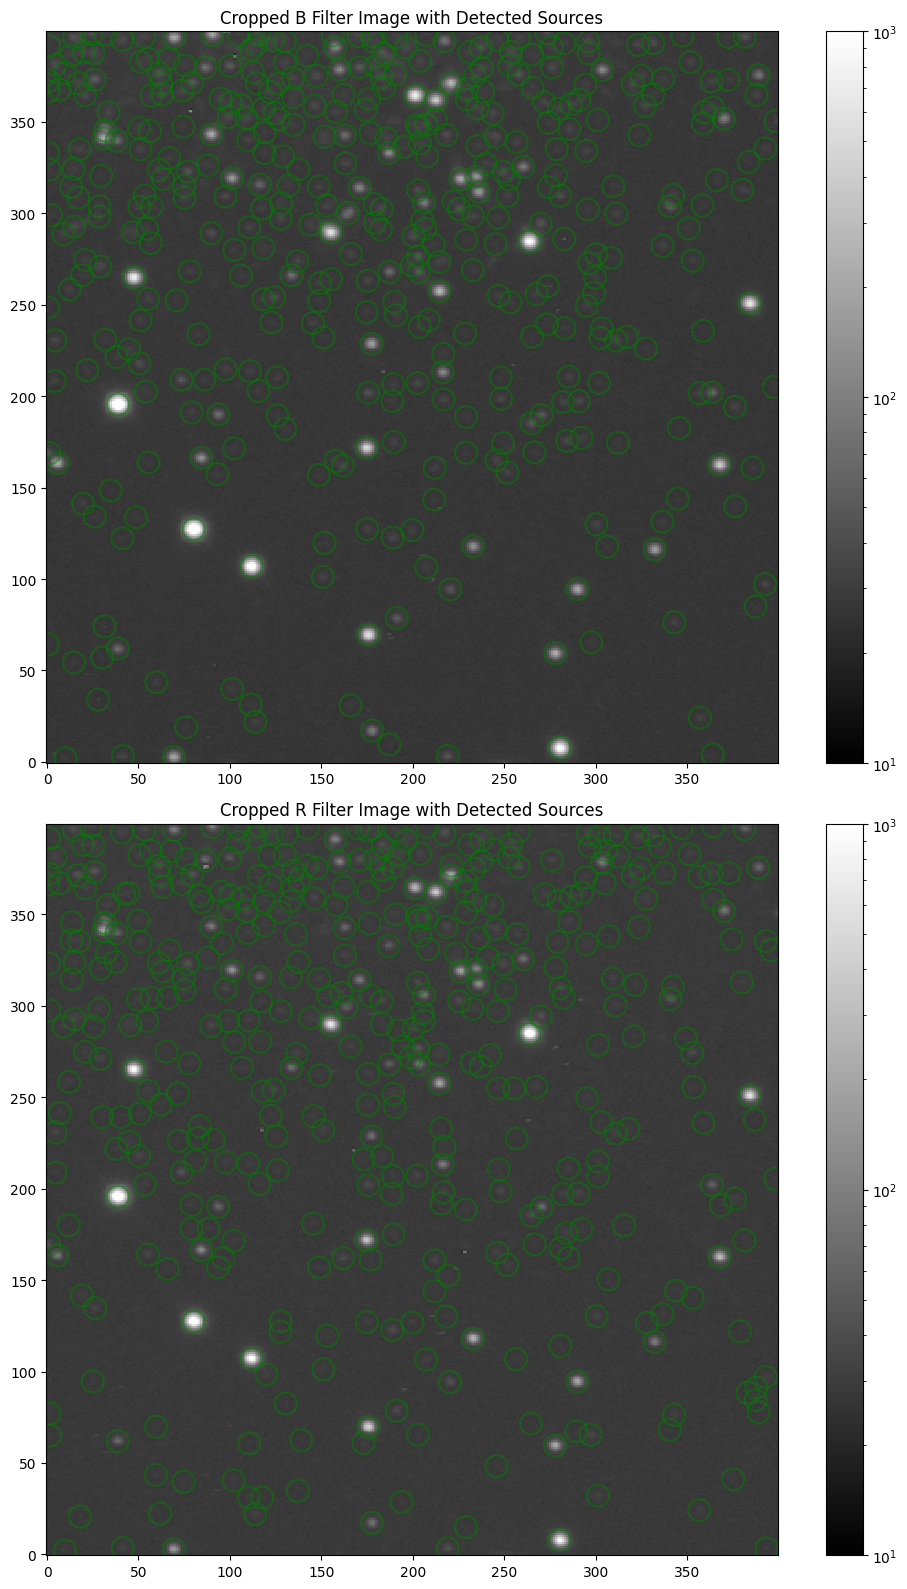

<Figure size 640x480 with 0 Axes>

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16))

# Positions for B filter sources
positions_b = np.transpose((b_filter_sources['xcentroid'], b_filter_sources['ycentroid']))
apertures_b = CircularAperture(positions_b, r=6.0)

# Plot the B filter image with apertures
img_b = ax1.imshow(cropped_b_filter_img, cmap= BLUE_FILTER_COLOR, origin='lower', norm=LogNorm(vmin=10, vmax=1000), interpolation='nearest')
ax1.set_title('Cropped B Filter Image with Detected Sources')
fig.colorbar(img_b, ax=ax1)
apertures_b.plot(color='green', lw=1.5, alpha=0.5, ax=ax1)

# Positions for R filter sources
positions_r = np.transpose((r_filter_sources['xcentroid'], r_filter_sources['ycentroid']))
apertures_r = CircularAperture(positions_r, r=6.0)

# Plot the R filter image with apertures
img_r = ax2.imshow(cropped_r_filter_img, cmap= RED_FILTER_COLOR, origin='lower', norm=LogNorm(vmin=10, vmax=1000), interpolation='nearest')
ax2.set_title('Cropped R Filter Image with Detected Sources')
fig.colorbar(img_r, ax=ax2)
apertures_r.plot(color='green', lw=1.5, alpha=0.5, ax=ax2)

# Adjust layout and save the figure
plt.tight_layout()
output_filepath = DIRECTORY + "DAOStarFinder Results.jpg"
plt.savefig(output_filepath, format='jpg')

# Display the plot
plt.show()
plt.clf()